In [1]:
import pandas as pd
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt

from tqdm import tqdm
from sentence_transformers import SentenceTransformer


In [2]:
# Check if GPU is available
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

In [22]:
# Load your data
file_path = 'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/suomi24.csv'
df = pd.read_csv(file_path)

# Define the hypotheses and encode them
hypotheses = [
    "Personal experiences with surveillance cameras significantly shape people's views on public monitoring.",
    "Attitudes toward surveillance cameras vary significantly depending on their placement in different settings, such as shopping areas, residential blocks, and workplaces.",
    "There are common technical complaints about surveillance cameras, and people suggest specific enhancements to address these issues.",
    "Surveillance cameras make people feel more secure rather than feeling watched.",
    "There is a noticeable relationship between the density of surveillance cameras in an area and public opinion regarding their presence."
]

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the SentenceTransformer model and send it to the device
model = SentenceTransformer("Snowflake/snowflake-arctic-embed-s").to(device)
hypothesis_embeddings = model.encode(hypotheses, convert_to_tensor=True, device=device).cpu()

# Save hypothesis embeddings
with open('hypothesis_embeddings.pkl', 'wb') as f:
    torch.save(hypothesis_embeddings, f)

You try to use a model that was created with version 2.7.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





In [4]:
# Load saved embeddings
hypothesis_embeddings = torch.load('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/hypothesis_embeddings.pkl')

In [20]:
texts = df['processed_text'].tolist()

# Generate embeddings in batches
batch_size = 10000
text_embeddings = []

for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
    batch_texts = texts[i:i + batch_size]
    batch_embeddings = model.encode(batch_texts, convert_to_tensor=True, device=device).cpu()
    text_embeddings.append(batch_embeddings)

# Concatenate all batches
text_embeddings = torch.cat(text_embeddings, dim=0)

# Save text embeddings
with open('text_embeddings.pkl', 'wb') as f:
    torch.save(text_embeddings, f)

Processing batches: 100%|██████████| 28/28 [03:03<00:00,  6.56s/it]


In [5]:
# Load saved embeddings
text_embeddings = torch.load('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/text_embeddings.pkl')

In [33]:
# Calculate cosine similarity between text and hypothesis embeddings
similarity_scores = torch.mm(text_embeddings, hypothesis_embeddings.T).cpu().numpy()

# Save similarity scores
with open('similarity_scores.pkl', 'wb') as f:
    pickle.dump(similarity_scores, f)

In [9]:
# similarity_scores = torch.load('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/similarity_scores.pkl')
# Loading with pickle
with open('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/suomi24/Data/similarity_scores.pkl', 'rb') as f:
    similarity_scores = pickle.load(f)

C:\Users\fahad\.conda\envs\torch\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\fahad\.conda\envs\torch\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


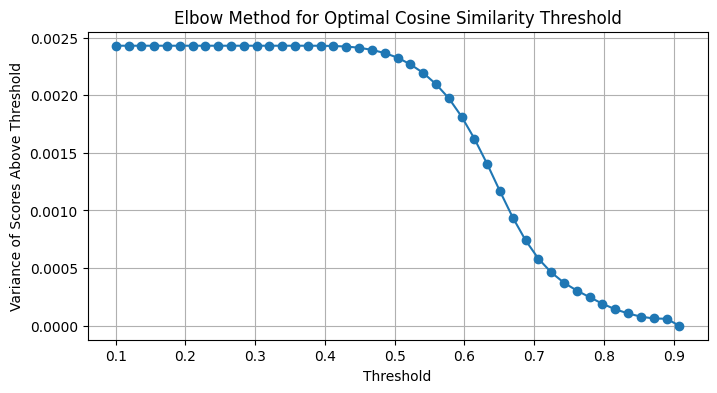

In [18]:
# Assuming 'similarity_scores' is a 2D array where each row corresponds to a document and each column to a hypothesis
thresholds = np.linspace(0.1, 1, 50)  # Adjust as needed for your range of similarity scores
variances = []

for threshold in thresholds:
    filtered_scores = similarity_scores[similarity_scores > threshold]
    variance = np.var(filtered_scores)
    variances.append(variance)

# Plotting the elbow plot
plt.figure(figsize=(8, 4))
plt.plot(thresholds, variances, marker='o')
plt.title('Elbow Method for Optimal Cosine Similarity Threshold')
plt.xlabel('Threshold')
plt.ylabel('Variance of Scores Above Threshold')
plt.grid(True)
plt.show()


In [27]:
threshold = 0.5
max_scores = np.max(similarity_scores, axis=1)
df_temp = pd.DataFrame()
df_temp['Max_Similarity_Score'] = max_scores
df_temp['classified'] = df_temp['Max_Similarity_Score'] >= threshold

# Count classified and unclassified
classified_count = df_temp['classified'].sum()
unclassified_count = (~df_temp['classified']).sum()

print(f"Classified Rows: {classified_count}")
print(f"Unclassified Rows: {unclassified_count}")


Classified Rows: 273016
Unclassified Rows: 288


In [28]:
threshold = 0.5
max_indices = np.argmax(similarity_scores, axis=1)  # Indices of max similarity score per row
max_scores = np.max(similarity_scores, axis=1)  # Max scores per row

# Map indices to hypothesis labels if score exceeds threshold, else assign -1
hypothesis_labels = {i: f'H{i}' for i in range(len(hypotheses))}
df['hypothesis'] = [hypothesis_labels[idx] if score > threshold else -1 for idx, score in zip(max_indices, max_scores)]

# Save the DataFrame with the hypothesis mapping
# df.to_csv('suomi24_with_hypotheses.csv', index=False)

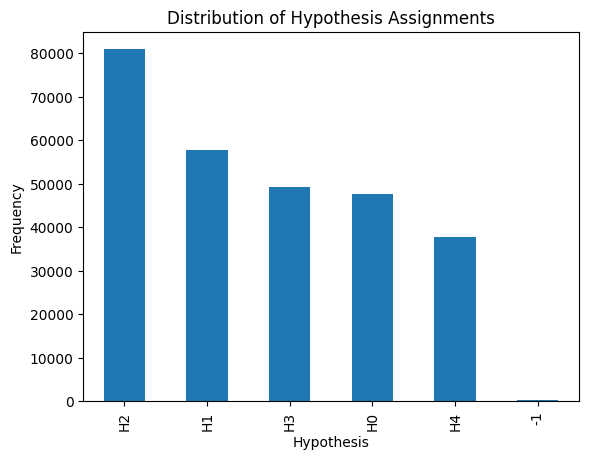

In [29]:
# Optional: Display a histogram of the assigned hypotheses
df['hypothesis'].value_counts().plot(kind='bar')
plt.title('Distribution of Hypothesis Assignments')
plt.xlabel('Hypothesis')
plt.ylabel('Frequency')
plt.show()

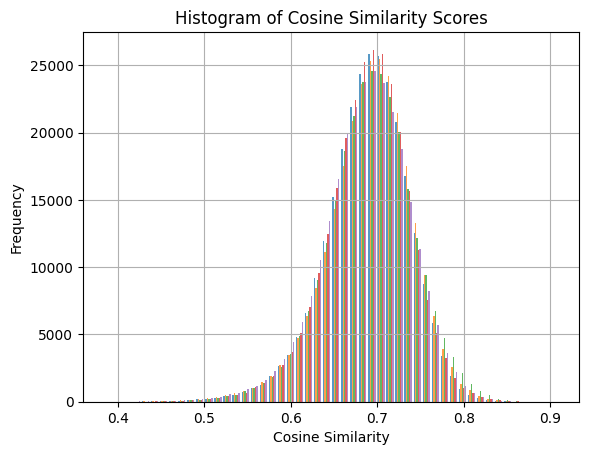

In [32]:
# Assuming `similarity_scores` is a numpy array of your cosine similarity scores
plt.hist(similarity_scores, bins=50, alpha=0.75)
plt.title('Histogram of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
